**Generalizing Dijkstra's algorithm to find optimal paths using different metrics.**

# Introduction

In this project I will apply a generalized variation of Dijkstra's algorithm to find optimal paths as defined by different criteria/metrics between two points in a network. To do so I will create a simulation of a network that will be represented as a graph and explore the alterations between the Djikstra's optimal paths when using different routing metrics.

## Dijkstra's Algorithm

Dijkstra's Algorithm is an optimal, uninformed search algorithm that finds the shortest path from a source node to the rest of the nodes in a graph. It is a greedy algorithm as it chooses the best/shortest choice at each step. Three things are needed for the process: Store the nodes distances and the previous node, mark nodes as visited and a pointer for the current node. The process is simple but effective:

1. Mark all nodes as not visited
2. Initialize the pointer at the start node
3. Initialize all nodes distances as infinity except for the source node for which the value 0 is assigned
    
  3.1. For the current node calculate the length of the path from the start node -that passes through the current node- to every unvisited neighbor nodes. If the distance is smaller than the previous value, update the distance and value of previous node.
  3.2. If the distance for every neighbor was calculated, mark the current node as visited. After that, the node never be considered again as its distance value is the minimum and thus it is now "locked".
  3.3. Set the current node pointer to the node with the minimum distance.

4. Repeat steps 3.1 - 3.3 until every node was visited

Dijkstra's shortest path algorithm has a time complexity of $O((|V|+|E||)log|V|) $, where $|V|$ is the number of nodes in the graph and $|E|$ is the number of edges.

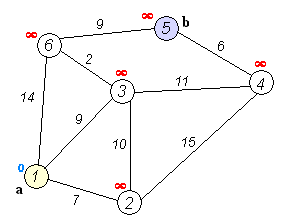

## Routing Metrics

The algorithm described above is used to find the shortest path between nodes. Instead of using different algorithms for different problems we can extended it in order to applicable in other path searching problems. We can do so by using metrics other than the length/weight of a path.

A routing metric is a unit calculated by an algorithm to chose a path through which the data will be transfered. For the purposes of this project, routing metrics will be formally expressed as a routing algebra over a semiring $(S, \oplus,⊗, e, n)$ as proposed in [1], where $S$ is a set of path weights, $⊕$ is a bilinear choice operator, $⊗$ is a bilinear extension operator, $e$ is the unit element which is the weight of the invalid path and $n$ is the null element which is the weight of the trivial path. Since the simultion used later is of an connected and acyclic graph there will be neither trivial nor invalid paths and as such from now one $e$ and $n$ will be omitted and the semiring will be simply expressed as $(S, \oplus,⊗)$

The extension operator concatenates the weights of two paths and returns a new weight and the choice operator is the function that selects between two paths the one that is preffered. Other representations can also be used [2][3] but the chosen one is more fitting for the purposes of this project.

\

[1] B. A. CARRÉ , "An Algebra for Network Routing Problems Get access Arrow", *IMA Journal of Applied Mathematics* vol.7, Issue 3, pp. 273–294, June 1971

[2] Karkazis, P., Trakadas, P., Leligou, H.C. et al. "Evaluating routing metric composition approaches for QoS differentiation in low power and lossy networks.", *Wireless Netw* vol.19, pp. 1269–1284, Dec. 2013

[3]  M.L Daggit, "An algebraic perspective on the convergence of vector-based routing protocols", *Apollo - University of Cambridge Repository*, Apr. 2019

The generalized version created has some fundamental differences with the algorithm described above. First of all, only the start node distance will be initialized. The rest are not initialized but their values are stored later on. Secondly, traditionally Dijkstra's algorithm is implemented using a priority queue that always pop's the item with smaller value but since shortest path isn't the only purpose of this generalized version of Dijkstra's, a priority queue will not help. Instead a dictionary is created to store the neighbors and next neighbor is selected customly using the choice operator. Lastly the "length" values are calculated by applying the custom metrics and are not just added like the traditional Dijkstra's.

# Import Libraries

For the creation and the visualization of the graph the package networkx will be used.

In [25]:
from itertools import combinations, groupby
import numpy as np
import networkx as nx
import random

# Usefull Functions

## Random Graph Creation

In [26]:
def random_weighted_connected_graph(n, p, min_weight=1, max_weight=10):
    """
    Generates a random weighted undirected acyclic connected graph.

    n -- number of nodes in graph
    p -- probability a node will be connected to another node
    max_weight -- the maximum weight that can be assigned to an edge
    """
    edges = combinations(range(n), 2)
    G = nx.Graph()
    G.add_nodes_from(range(n))
    if p <= 0:
        return G
    if p >= 1:
        return nx.complete_graph(n, create_using=G, weights=random.randint(min_weight, max_weight))
    for _, node_edges in groupby(edges, key=lambda x: x[0]):
        node_edges = list(node_edges)
        random_edge = random.choice(node_edges)
        G.add_edge(*random_edge, weight=random.randint(min_weight, max_weight))
        
        for e in node_edges:
            if random.random() < p:
                G.add_edge(*e, weight=random.randint(min_weight ,max_weight))

    return G



## Dijkstra's Algorithm

In [27]:
def dijkstra(graph, start, end, metric):


  # Calculate the result of the extension operator
  def calc_metric(current_node, next_node, current_weight):
    if metric == 'hop':
      extension = current_weight + 1
    elif metric == 'shortest_path':
      extension = current_weight + graph.get_edge_data(current_node, next_node)['weight']
    elif metric == 'widest_path':
    
      # If start node return edge weight
      if current_node == start:
        return graph.get_edge_data(current_node, next_node)['weight']
     
      extension = min(graph.get_edge_data(current_node, next_node)['weight'], current_weight)

    return extension


  # Apply the neighbors choice operator
  def choose_destination(destinations):
    # If start return itself
    if destinations == start:
      return start

    if metric == 'hop':
      choice = np.random.choice(list(destinations.keys()))
      # choice = np.random.choice(destinations, key=lambda k: destinations[k][1])
    elif metric == 'shortest_path':
      choice = min(destinations, key=lambda k: destinations[k][1])
    elif metric == 'widest_path':
      choice = max(destinations, key=lambda k: destinations[k][1])

    return choice

  # Initialize
  shortest_paths = {start: (None, 0)}  # dictionary of shotest paths
  current_node = start  # current node pointer
  next_node = start
  visited = set()  # set of visited nodes
  destinations = current_node

  # Iterate through every node
  while destinations:
      # print(shortest_paths)
      # print(visited)
      current_node = choose_destination(destinations)  # Apply choice operator    
      visited.add(current_node)
      destinations = [node[1] for node in list(graph.edges(current_node))]  # Neighbors
      weight_to_current_node = shortest_paths[current_node][1]
      # Iterate through neighbors
      for next_node in destinations:
          if next_node in visited:
            continue
          weight = calc_metric(current_node, next_node, weight_to_current_node) # Apply metric
          # Add weight and previous node
          if next_node not in shortest_paths:
              shortest_paths[next_node] = (current_node, weight)
          else:
              current_shortest_weight = shortest_paths[next_node][1]
              # Update weight and previous node if needed
              if (metric == 'hop' or metric == 'shortest_path') and (current_shortest_weight > weight):
                  shortest_paths[next_node] = (current_node, weight)
              elif (metric == 'widest_path') and (current_shortest_weight <= weight):
                  shortest_paths[next_node] = (current_node, weight)
      # Possible nodes to visit next
      destinations = {node: shortest_paths[node] for node in shortest_paths if node not in visited}
  # Work back through destinations in shortest path
  path = []
  current_node = end
  while current_node is not None:
      path.append(current_node)
      next_node = shortest_paths[current_node][0]
      current_node = next_node
  # Reverse path
  path = path[::-1]
  return path, shortest_paths[end][1]

# Simulation

Create a random, undirected, weighted, acyclic, connected graph to simulate a simple network with such characteristics and select two random nodes as start and end nodes.


Start node: 6, End node: 0


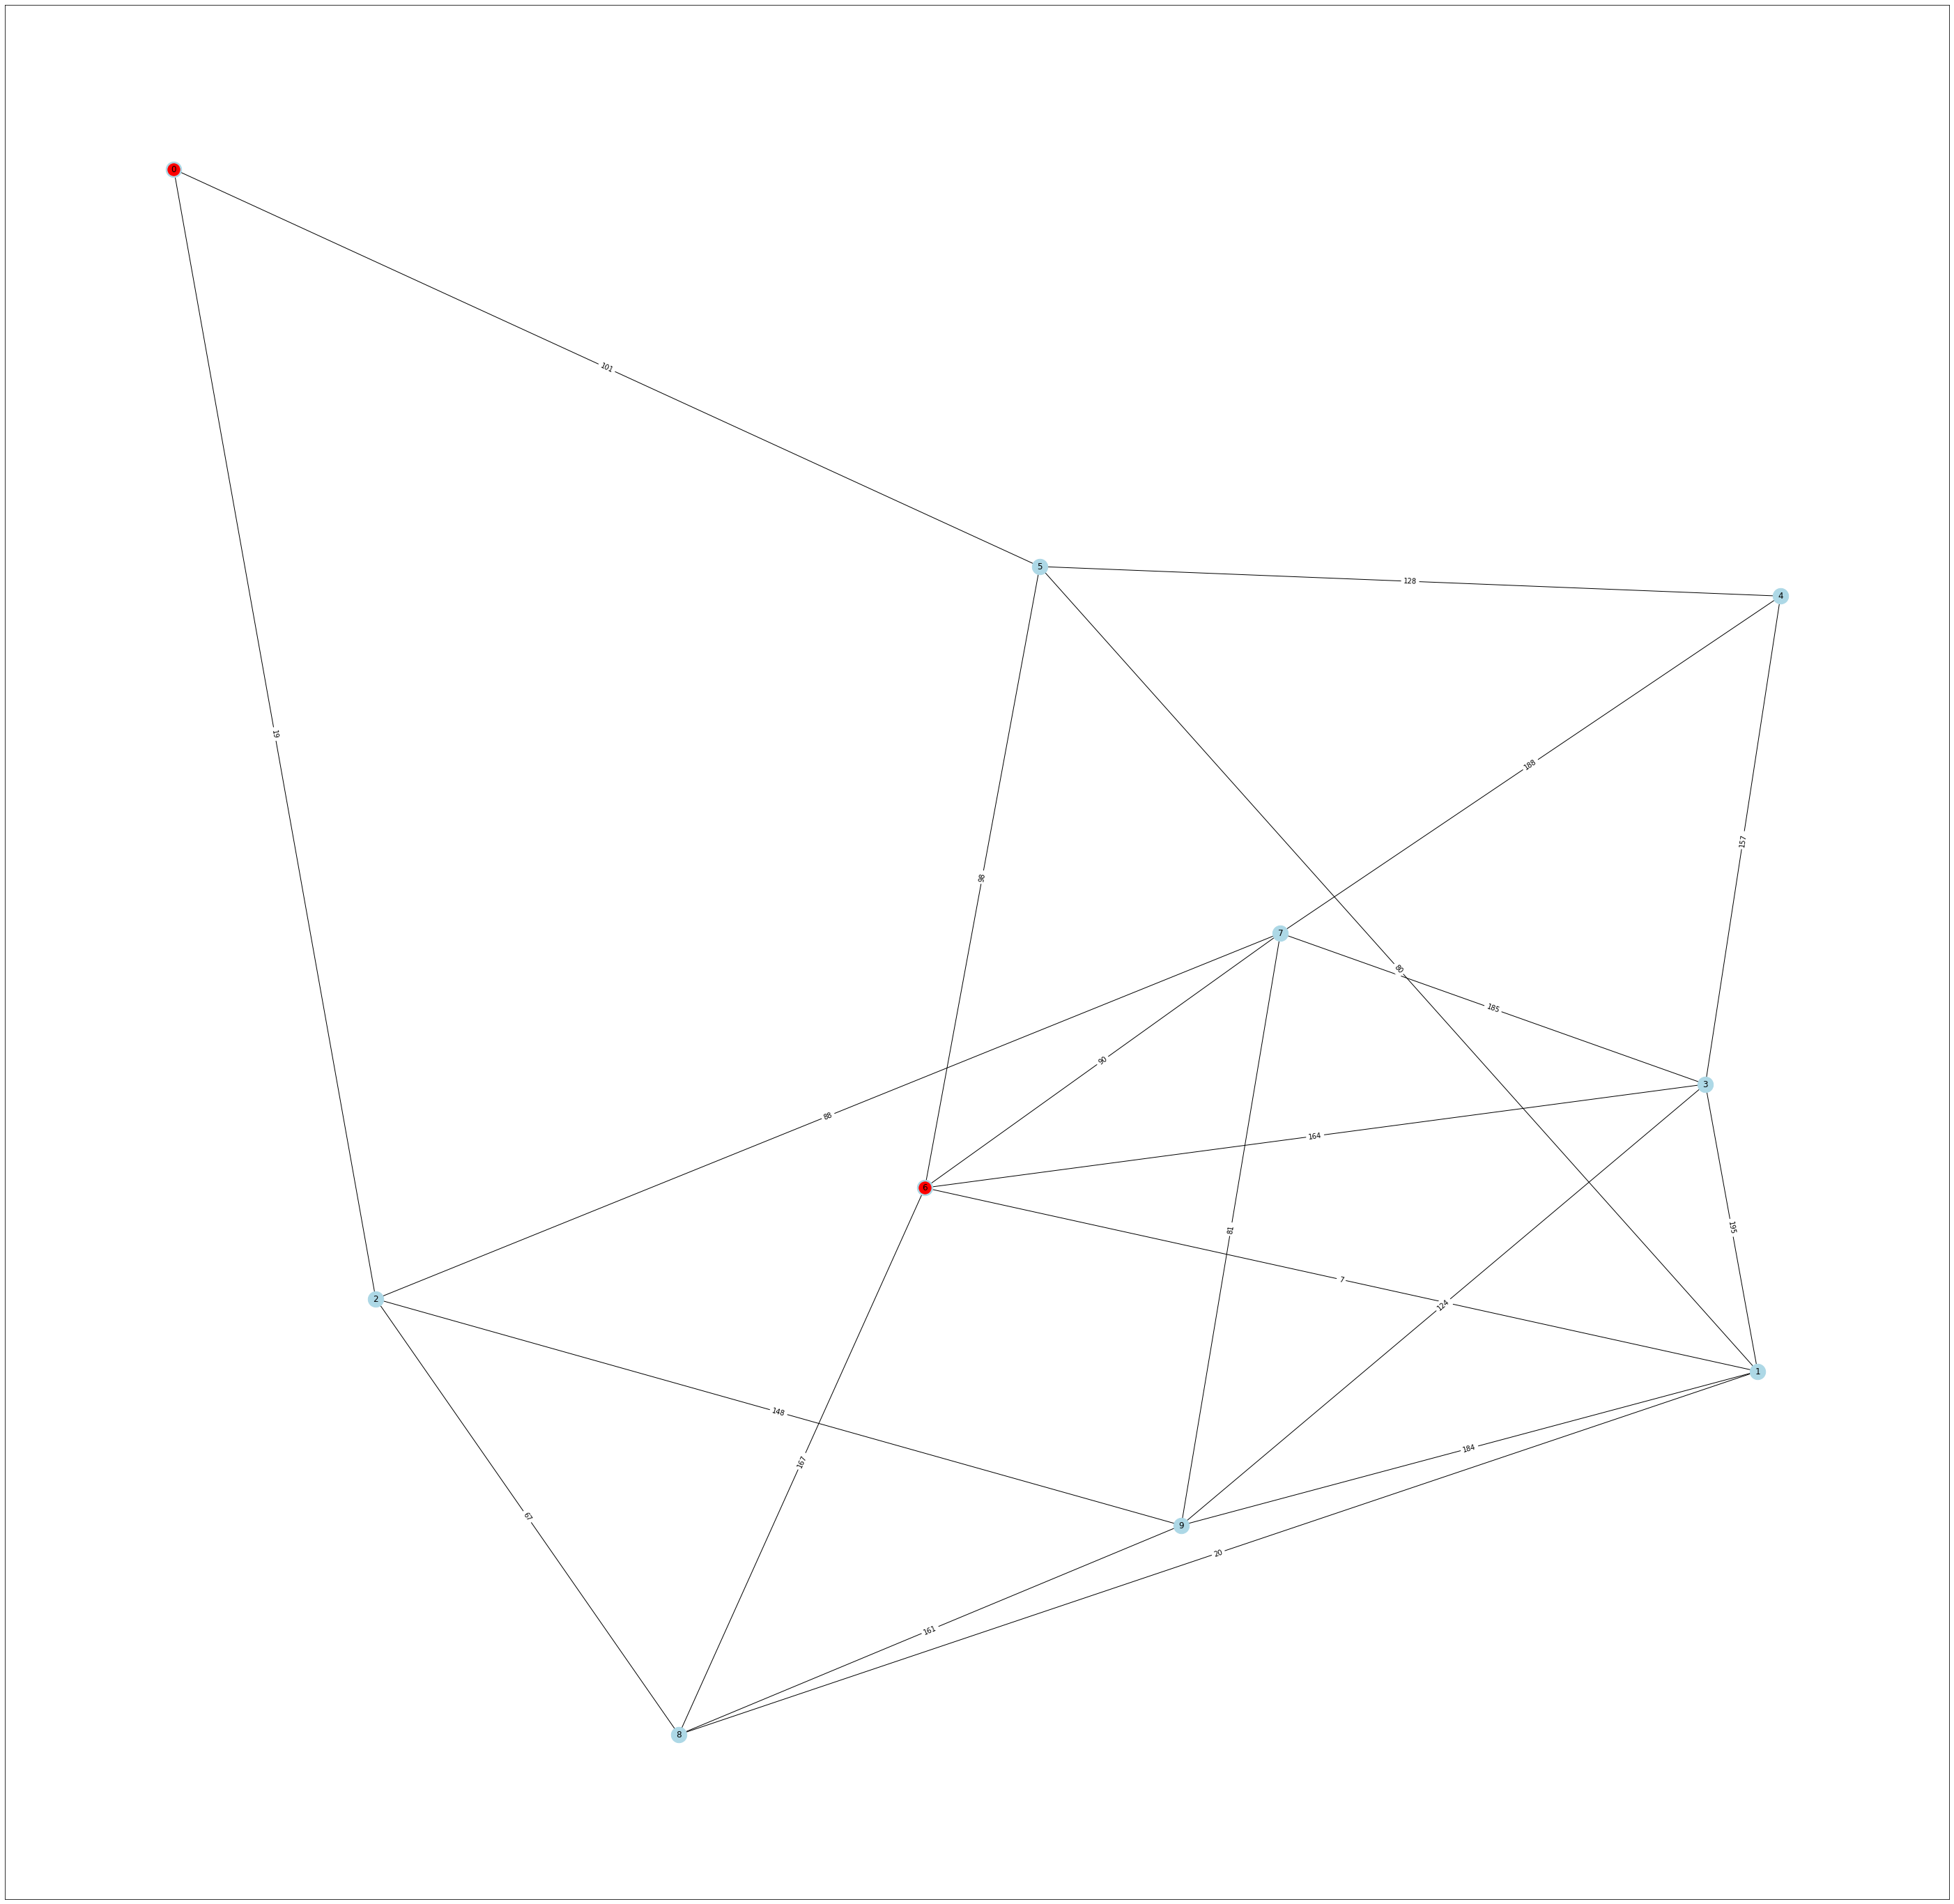

In [40]:
from matplotlib import pyplot as plt

nodes = 10  # number of nodes
probability = 0.5  # Probability a node will be connected to another
G = random_weighted_connected_graph(nodes, probability, min_weight=1 , max_weight=200)  # Generate graph

# Randomly select start and end nodes
start_node = np.random.choice(list(G.nodes()))
end_node = start_node
# Make sure they're not the same
while end_node == start_node:
  end_node = np.random.choice(list(G.nodes()))

print(f"Start node: {start_node}, End node: {end_node}")

# Plot graph and start and end nodes
plt.figure(figsize=(50, 50))

pos = nx.spring_layout(G, k=1)
weights = nx.get_edge_attributes(G, "weight")
nx.draw_networkx(G, pos, with_labels=True, node_color='lightblue', node_size=500)
nx.draw_networkx_nodes(G,pos,nodelist=[start_node, end_node],node_color='r')
nx.draw_networkx_edge_labels(G, pos, edge_labels=weights);

# Metrics

## Hop Count

**Hop count** is a routing metric that counts the **number of nodes** -regardless of the edges weight- the data must traverse through in order to reach the final destination. This routing protocol selects the path with the less hop counts. This is same as using Djikstra's to find the shortest path on an unweighted graph. Since the weights are not taken into consideration the  next node is chosen randomly from the neighbor nodes. The algorithm described above is the BFS algorithm with a randomly selected neighbors. We can formally represent this routing metric as:

$Hop \ Count = (\mathbb{N}, min, f)$, where $f$ is:

$$f(x,y)=x+1, \ \ \ \ \ \ \ \ \ ∀ \ \ x,y\in \mathbb{N}$$

\

$x$ is the path length so far (number of hops) and $y$ is length of the new edge to be concatenated with $x$. $min(paths)$ is the path with the less hop counts.

In [42]:
# Get path with less hops
min_hop_path, hops = dijkstra(G, start_node, end_node, metric='hop')

print(f"Minimum Hops Path from {start_node} to {end_node}: \n")
print('Minimum Hops: ', hops)
print('Path: ', min_hop_path)

Minimum Hops Path from 6 to 0: 

Minimum Hops:  2
Path:  [6, 5, 0]


## Shortest Path

**Shortest path** is a routing metric that **sums the weights** of the edges the data will traverse in order to reach the destination node. When using this routing metric we are performing Dijkstra's shortest path algorithm on a weighted graph. Formally we can represent it as:

$Shortest \ Path = \{\mathbb{N},min,f\}$, where $f$ is:

$$f(x,y) = x + y, \ \ \ \ \ \ \ \ \ ∀ \ \ x,y\in \mathbb{N}$$

\\

$x$ is the sum of weights so far and $y$ is the weight of the new edge. $min(paths)$ is the path with the shortest length.

In [43]:
# Get shortest path
shortest_path, length = dijkstra(G, start_node, end_node, metric='shortest_path')

print(f"Shortest Path from {start_node} to {end_node}: \n")
print('Minimum Length: ', length)
print('Path: ', shortest_path)

Shortest Path from 6 to 0: 

Minimum Length:  113
Path:  [6, 1, 8, 2, 0]


## Widest Path

We will now consider the **Widest path** problem. Here the routing metric is the one that finds the minimum edge weight in a path and the routing protocol selects the path with the biggest routing metric value (**Maximum of the minimum**). The widest path problem when applied to the network of routers connecting to the internet represents the bandwidth of the connection between two routers ie. the maximum transfer rate of data. Formally we can represent it as:

$Widest \ Path = \{ \mathbb{N}, max, min\}$

were $min(x,y)$ is the minimum between the path width so far and the width of the new edge and $max(paths)$ is the path with the maximum final width.

In [44]:
# Get widest path
widest_path, width = dijkstra(G, start_node, end_node, 'widest_path')

print(f"Widest Path from {start_node} to {end_node}: \n")
print('Max Width: ', width)
print('Path: ', widest_path)

Widest Path from 6 to 0: 

Max Width:  101
Path:  [6, 3, 7, 4, 5, 0]


## Plot the different paths

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instanc

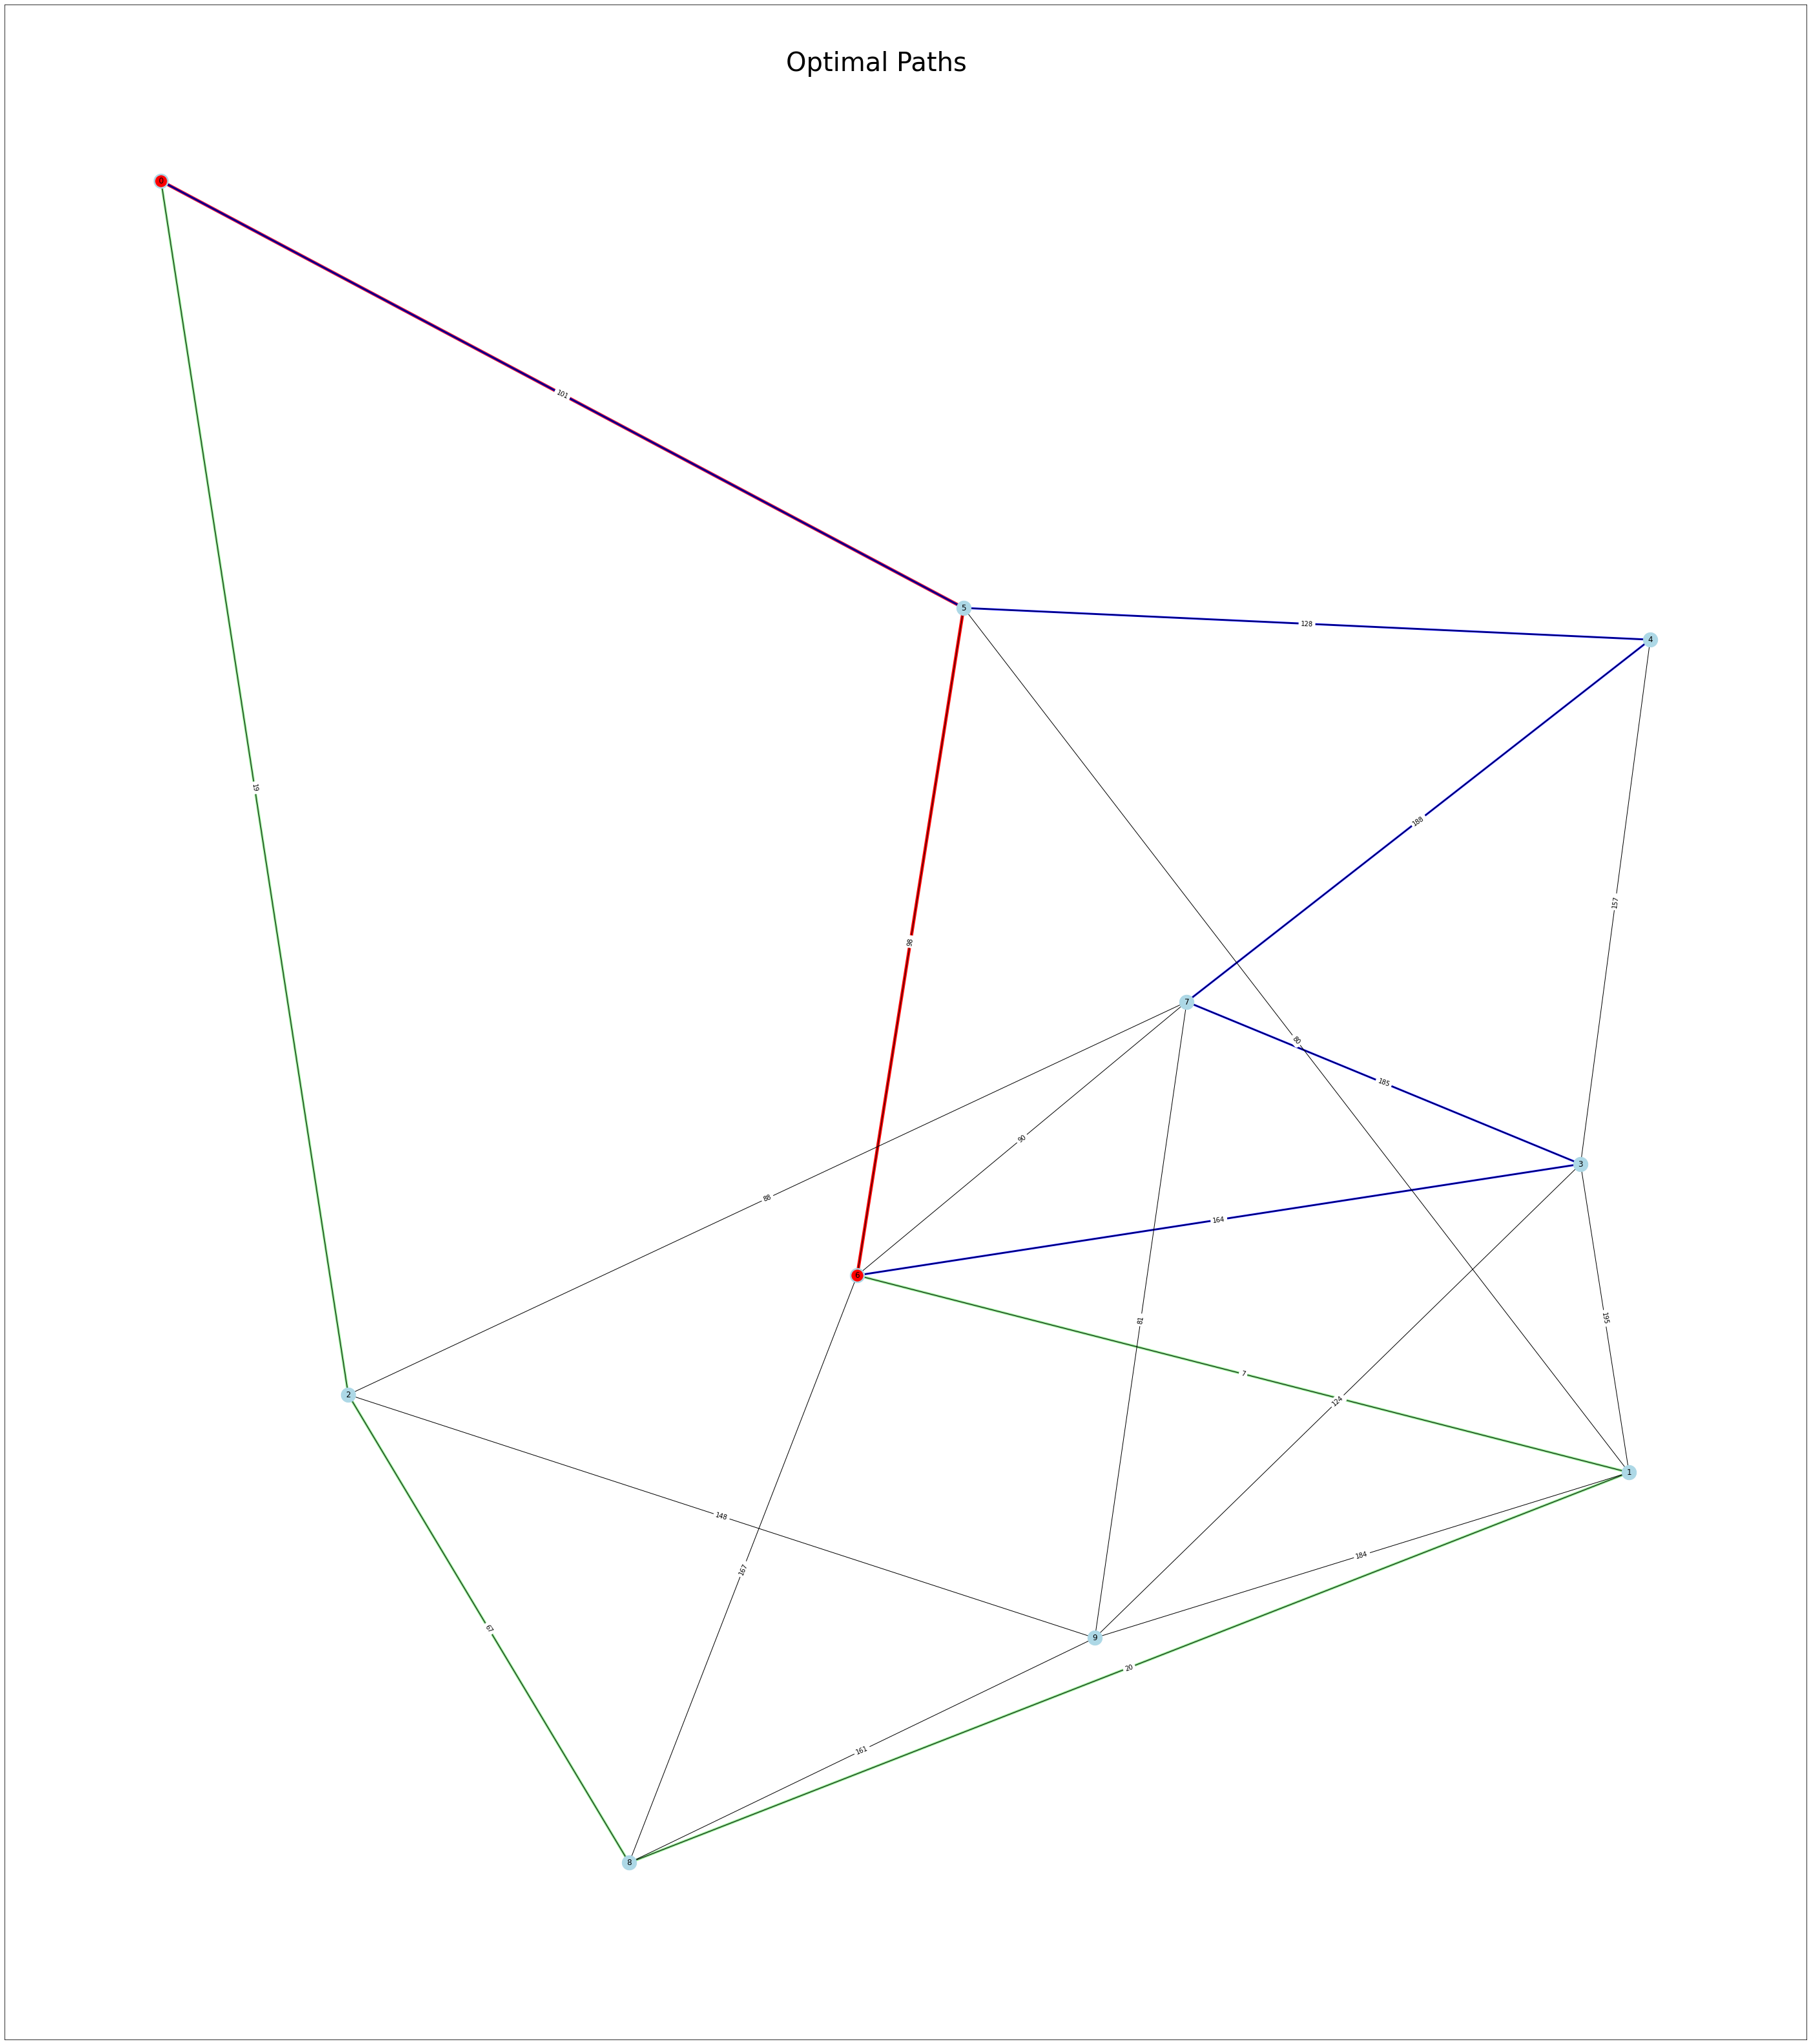

In [45]:
# Plot the graph and the shortest path
weights = nx.get_edge_attributes(G, "weight")
min_hop_edges = list(zip(min_hop_path,min_hop_path[1:]))
shortest_edges = list(zip(shortest_path, shortest_path[1:]))
widest_edges = list(zip(widest_path, widest_path[1:]))

fig = plt.figure(figsize=(50,50))

# Plot Minimum Hop Path
ax1 = fig.add_subplot(1,1,1)
nx.draw_networkx_nodes(G,pos,nodelist=min_hop_path, node_color='r', ax=ax1);
ax2 = fig.add_subplot(1,1,1) 
nx.draw_networkx_edges(G,pos,edgelist=min_hop_edges, edge_color='r',width=5, ax=ax2);


# Plot Shortest Path
ax3 = fig.add_subplot(1,1,1)
nx.draw_networkx_nodes(G,pos,nodelist=shortest_path,node_color='lightgreen', ax=ax3);
ax4 = fig.add_subplot(1,1,1) 
nx.draw_networkx_edges(G,pos,edgelist=shortest_edges,edge_color='lightgreen',width=4, ax=ax4);

# Plot Widest Path
ax5 = fig.add_subplot(1,1,1)
nx.draw_networkx_nodes(G,pos,nodelist=widest_path, node_color='blue', ax=ax5);
ax6 = fig.add_subplot(1,1,1) 
nx.draw_networkx_edges(G,pos,edgelist=widest_edges, edge_color='blue',width=3, ax=ax6);

ax7 = fig.add_subplot(1,1,1) 
nx.draw_networkx(G, pos, with_labels=True, node_color='lightblue', node_size=500, ax=ax3);
ax8 = fig.add_subplot(1,1,1)
nx.draw_networkx_nodes(G,pos,nodelist=[start_node, end_node],node_color='r')
nx.draw_networkx_edge_labels(G,pos,edge_labels=weights);

fig.suptitle('Optimal Paths', fontsize=40)
fig.subplots_adjust(top=1)

# Conclusion

As can be seen from the graph above, by generalizing Dijkstra's algorithm we managed to find optimal paths for various different metrics succesfully. Other than Computer/Router Networks, the above generalization can be usefull in other types of networks that the Dijkstra's algorithm can be used. Some examples 
- finding the route that has the less tolls using the $Hop \ Count$ metric. 

- find the best exit route in a building in case of an evacuation using $Widest \ Path$ metric. 

- Create a strategy for a two player game using the metric $MiniMax = \{ \mathbb{N}, min, max\}$ that minimizes the maximum loss. The player tries to minimize the maximum advantage of the oponent.